<a href="https://colab.research.google.com/github/agarr3/vajra-new-2/blob/main/AE_HYBRID_WESTERN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1



DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/"
DATA_SONG_DIR = "originals"
DATA_IMG_DIR = "originals"
input_bins = 48
BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/"



seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
print(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "Western_numpy"))
             
train_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      train_files.append([file,file, "Western_numpy"])
    else:
      print(file)



for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Indian_numpy")):
  for file in fileList:
    if(True):
      train_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

train_data = pd.DataFrame(train_files, columns=['Images','songs','labels'])
train_data.head()

/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/originals/Western_numpy


,Images,songs,labels
0,western_011918_mel_1.npy,western_011918_mel_1.npy,Western_numpy
1,western_017500_mel_0.npy,western_017500_mel_0.npy,Western_numpy
2,western_001701_mel_0.npy,western_001701_mel_0.npy,Western_numpy
3,western_011242_mel_1.npy,western_011242_mel_1.npy,Western_numpy
4,western_012387_mel_0.npy,western_012387_mel_0.npy,Western_numpy


In [5]:
test_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      test_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
test_files = random.sample(test_files, len(test_files))

for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Indian_numpy")):
  for file in fileList:
    if(True):
      test_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

test_data = pd.DataFrame(test_files, columns=['Images','songs','labels'])
test_data.head()

,Images,songs,labels
0,western_003707_mel_1.npy,western_003707_mel_1.npy,Western_numpy
1,western_000718_mel_1.npy,western_000718_mel_1.npy,Western_numpy
2,western_000890_mel_1.npy,western_000890_mel_1.npy,Western_numpy
3,western_000667_mel_1.npy,western_000667_mel_1.npy,Western_numpy
4,western_003895_mel_1.npy,western_003895_mel_1.npy,Western_numpy


In [6]:
train_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2811,2811
Western_numpy,1400,1400


In [7]:
test_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,1205,1205
Western_numpy,600,600


/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/originals/test/Western_numpy/western_011947_mel_1.npy
80.0


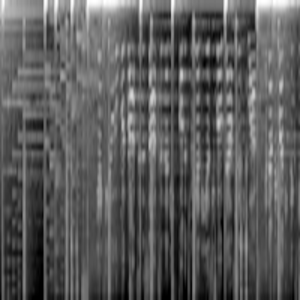

In [10]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", test_data.loc[test_idx, 'labels'], test_data.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



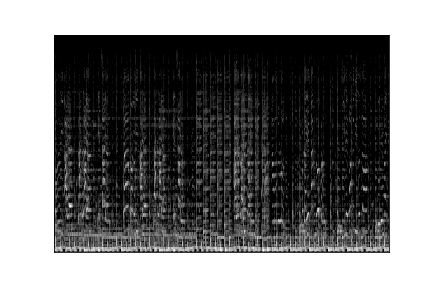

In [11]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [12]:
lb = LabelEncoder()
train_data['encoded_labels'] = lb.fit_transform(train_data['labels'])
train_data.head()

,Images,songs,labels,encoded_labels
0,western_011918_mel_1.npy,western_011918_mel_1.npy,Western_numpy,1
1,western_017500_mel_0.npy,western_017500_mel_0.npy,Western_numpy,1
2,western_001701_mel_0.npy,western_001701_mel_0.npy,Western_numpy,1
3,western_011242_mel_1.npy,western_011242_mel_1.npy,Western_numpy,1
4,western_012387_mel_0.npy,western_012387_mel_0.npy,Western_numpy,1


In [13]:
test_data['encoded_labels'] = lb.transform(test_data['labels'])
test_data.head()

,Images,songs,labels,encoded_labels
0,western_003707_mel_1.npy,western_003707_mel_1.npy,Western_numpy,1
1,western_000718_mel_1.npy,western_000718_mel_1.npy,Western_numpy,1
2,western_000890_mel_1.npy,western_000890_mel_1.npy,Western_numpy,1
3,western_000667_mel_1.npy,western_000667_mel_1.npy,Western_numpy,1
4,western_003895_mel_1.npy,western_003895_mel_1.npy,Western_numpy,1


In [14]:
classes = ('Indian_numpy', 'Western_numpy')
train_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2811,2811
Western_numpy,1,1400,1400


In [15]:
test_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205
Western_numpy,1,600,600


In [16]:
from sklearn.model_selection import train_test_split

train_data_combined = train_data.copy(deep=True)
test_data_combined = test_data.copy(deep=True)

train_data = train_data[train_data['labels'] == "Western_numpy"]
test_data = test_data[test_data['labels'] == "Western_numpy"]


#df_train, df_test = train_test_split(data, test_size=validation_split, stratify=data[["labels"]])

df_train = train_data.reset_index(drop=True)
df_test = test_data.reset_index(drop=True)


In [17]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Western_numpy,1,1400,1400


In [18]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Western_numpy,1,600,600


In [19]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [20]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        fileName = self.img_data.loc[index, 'Images']
        return data, label, fileName



In [22]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training"),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test"),transform)

train_dataset_combined = MEL_Dataset(train_data_combined,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training"),transform)
test_dataset_combined = MEL_Dataset(test_data_combined,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test"),transform)

In [23]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

trainloader_combined = torch.utils.data.DataLoader(train_dataset_combined, batch_size=batch_size)
testloader_combined = torch.utils.data.DataLoader(test_dataset_combined, batch_size=batch_size)

In [24]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

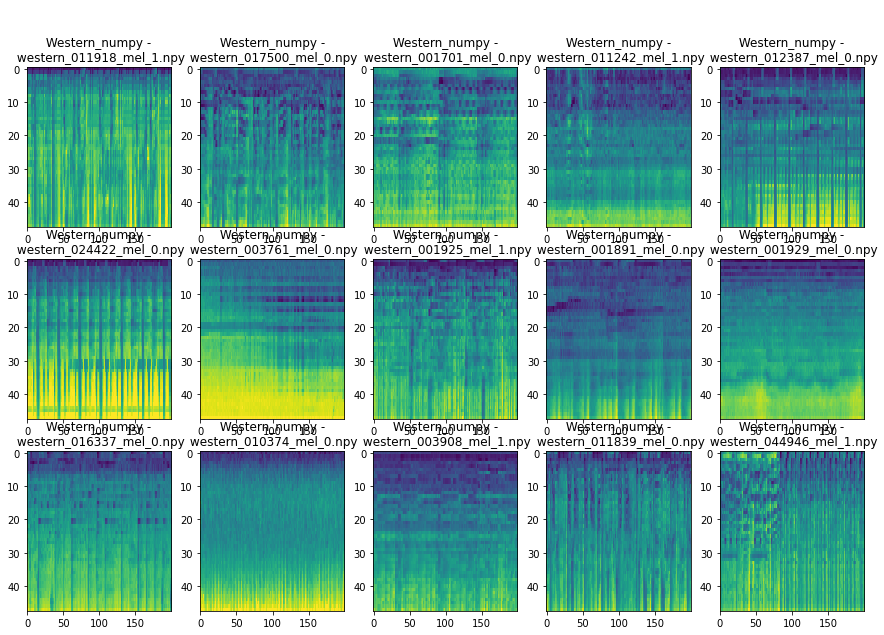

In [25]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, fileName = images[i], labels[i], fileNames[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"\n \n {arthopod_types[label.item()]} - \n {fileName}") # add label

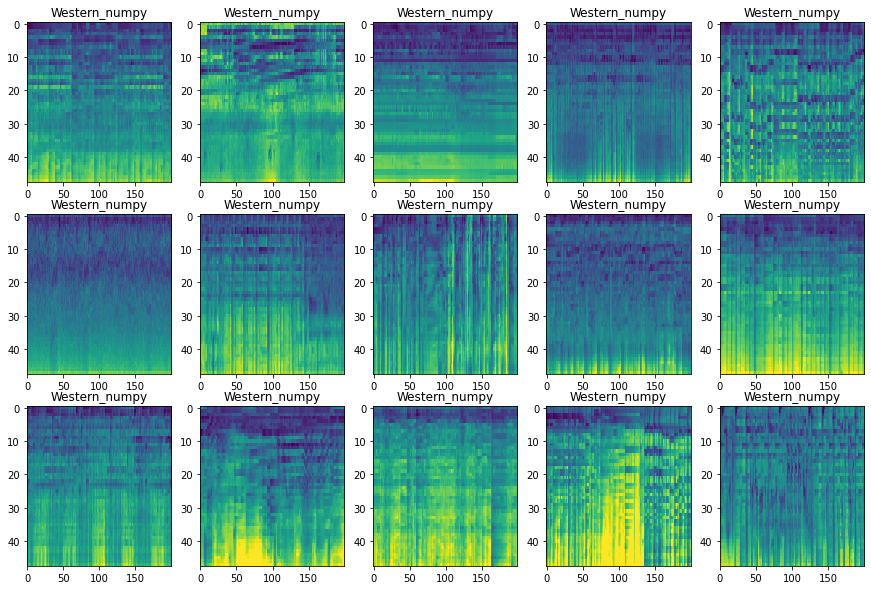

In [26]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [27]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [28]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1438.376
[1,     2] loss: 1452.558
[1,     3] loss: 1410.627
[1,     4] loss: 1116.040
[1,     5] loss: 1188.104
[1,     6] loss: 856.526
[1,     7] loss: 627.780
[1,     8] loss: 302.245
[1,     9] loss: 228.265
[1,    10] loss: 395.357
[1,    11] loss: 269.538
[1,    12] loss: 161.633
[1,    13] loss: 164.901
[1,    14] loss: 161.786
[1,    15] loss: 223.389
[1,    16] loss: 242.835
[1,    17] loss: 187.617
[1,    18] loss: 173.876
[1,    19] loss: 185.127
[1,    20] loss: 140.441
[1,    21] loss: 144.963
[1,    22] loss: 182.640
LOSS of the network on the train images after epoch 0 is 11254.622833251953
Mean of the network on the train images after epoch 0 is 535.9344206310454
LOSS of the network on the test images: 1868 %
Mean of the network on the train images after epoch 0 is 207.58213467068143


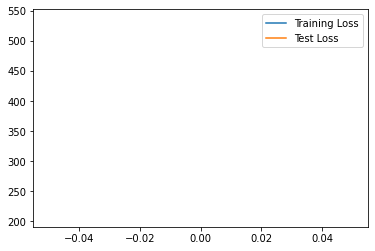

[2,     1] loss: 179.486
[2,     2] loss: 172.364
[2,     3] loss: 173.858
[2,     4] loss: 128.300
[2,     5] loss: 139.580
[2,     6] loss: 122.460
[2,     7] loss: 137.854
[2,     8] loss: 105.417
[2,     9] loss: 129.220
[2,    10] loss: 153.509
[2,    11] loss: 124.085
[2,    12] loss: 144.835
[2,    13] loss: 150.491
[2,    14] loss: 130.798
[2,    15] loss: 134.998
[2,    16] loss: 133.465
[2,    17] loss: 120.706
[2,    18] loss: 134.662
[2,    19] loss: 147.813
[2,    20] loss: 128.641
[2,    21] loss: 120.247
[2,    22] loss: 135.135
LOSS of the network on the train images after epoch 1 is 3047.9243087768555
Mean of the network on the train images after epoch 1 is 145.13925279889787
LOSS of the network on the test images: 1397 %
Mean of the network on the train images after epoch 1 is 155.27318488226996


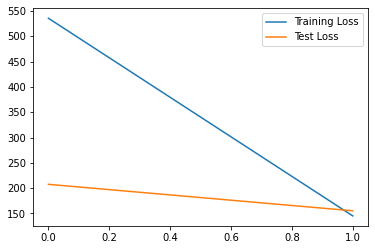

[3,     1] loss: 128.971
[3,     2] loss: 120.196
[3,     3] loss: 142.035
[3,     4] loss: 99.279
[3,     5] loss: 133.308
[3,     6] loss: 113.625
[3,     7] loss: 126.172
[3,     8] loss: 96.173
[3,     9] loss: 112.339
[3,    10] loss: 121.337
[3,    11] loss: 113.165
[3,    12] loss: 130.027
[3,    13] loss: 135.230
[3,    14] loss: 118.745
[3,    15] loss: 125.166
[3,    16] loss: 124.101
[3,    17] loss: 101.246
[3,    18] loss: 113.252
[3,    19] loss: 124.765
[3,    20] loss: 105.520
[3,    21] loss: 105.973
[3,    22] loss: 111.414
LOSS of the network on the train images after epoch 2 is 2602.0387115478516
Mean of the network on the train images after epoch 2 is 123.90660531180245
LOSS of the network on the test images: 1143 %
Mean of the network on the train images after epoch 2 is 127.04418860541449


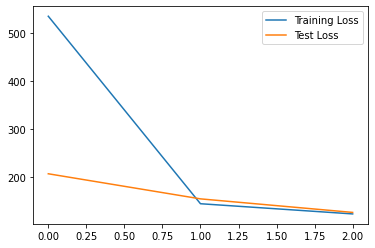

[4,     1] loss: 101.626
[4,     2] loss: 102.249
[4,     3] loss: 110.763
[4,     4] loss: 81.975
[4,     5] loss: 101.761
[4,     6] loss: 80.756
[4,     7] loss: 92.351
[4,     8] loss: 72.968
[4,     9] loss: 77.078
[4,    10] loss: 75.358
[4,    11] loss: 75.075
[4,    12] loss: 78.238
[4,    13] loss: 85.411
[4,    14] loss: 82.168
[4,    15] loss: 96.115
[4,    16] loss: 86.859
[4,    17] loss: 73.037
[4,    18] loss: 77.141
[4,    19] loss: 78.568
[4,    20] loss: 71.091
[4,    21] loss: 82.707
[4,    22] loss: 76.074
LOSS of the network on the train images after epoch 3 is 1859.368766784668
Mean of the network on the train images after epoch 3 is 88.54136984688895
LOSS of the network on the test images: 805 %
Mean of the network on the train images after epoch 3 is 89.48266516791449


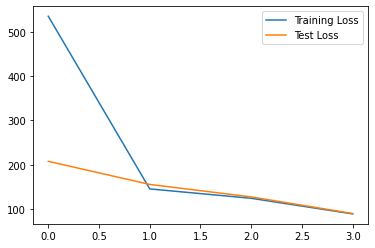

[5,     1] loss: 70.960
[5,     2] loss: 83.427
[5,     3] loss: 85.237
[5,     4] loss: 68.199
[5,     5] loss: 87.769
[5,     6] loss: 68.182
[5,     7] loss: 81.616
[5,     8] loss: 68.148
[5,     9] loss: 72.588
[5,    10] loss: 72.041
[5,    11] loss: 73.393
[5,    12] loss: 75.957
[5,    13] loss: 81.331
[5,    14] loss: 77.664
[5,    15] loss: 86.491
[5,    16] loss: 81.622
[5,    17] loss: 69.347
[5,    18] loss: 75.956
[5,    19] loss: 79.037
[5,    20] loss: 69.641
[5,    21] loss: 83.385
[5,    22] loss: 74.810
LOSS of the network on the train images after epoch 4 is 1686.8031768798828
Mean of the network on the train images after epoch 4 is 80.32396080380394
LOSS of the network on the test images: 797 %
Mean of the network on the train images after epoch 4 is 88.60149214002821


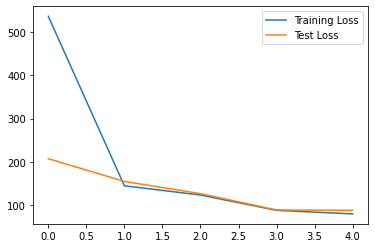

[6,     1] loss: 70.773
[6,     2] loss: 82.856
[6,     3] loss: 83.610
[6,     4] loss: 66.816
[6,     5] loss: 86.762
[6,     6] loss: 67.251
[6,     7] loss: 81.173
[6,     8] loss: 67.611
[6,     9] loss: 72.854
[6,    10] loss: 71.207
[6,    11] loss: 73.318
[6,    12] loss: 75.353
[6,    13] loss: 80.766
[6,    14] loss: 77.288
[6,    15] loss: 85.841
[6,    16] loss: 80.923
[6,    17] loss: 68.951
[6,    18] loss: 75.194
[6,    19] loss: 76.710
[6,    20] loss: 68.901
[6,    21] loss: 81.802
[6,    22] loss: 73.807
LOSS of the network on the train images after epoch 5 is 1669.7658462524414
Mean of the network on the train images after epoch 5 is 79.51265934535435
LOSS of the network on the test images: 781 %
Mean of the network on the train images after epoch 5 is 86.88047875298395


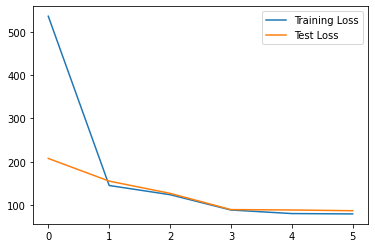

[7,     1] loss: 69.021
[7,     2] loss: 81.513
[7,     3] loss: 82.286
[7,     4] loss: 65.396
[7,     5] loss: 86.219
[7,     6] loss: 66.554
[7,     7] loss: 79.818
[7,     8] loss: 67.170
[7,     9] loss: 71.805
[7,    10] loss: 70.591
[7,    11] loss: 72.586
[7,    12] loss: 74.788
[7,    13] loss: 80.014
[7,    14] loss: 76.752
[7,    15] loss: 85.099
[7,    16] loss: 80.467
[7,    17] loss: 68.234
[7,    18] loss: 74.961
[7,    19] loss: 76.390
[7,    20] loss: 68.431
[7,    21] loss: 81.478
[7,    22] loss: 73.465
LOSS of the network on the train images after epoch 6 is 1653.0377044677734
Mean of the network on the train images after epoch 6 is 78.71608116513207
LOSS of the network on the test images: 779 %
Mean of the network on the train images after epoch 6 is 86.57377454969618


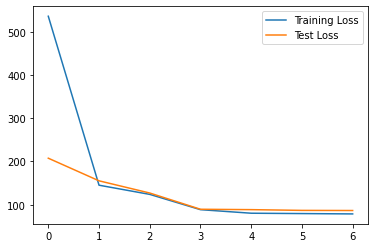

[8,     1] loss: 68.867
[8,     2] loss: 81.445
[8,     3] loss: 81.876
[8,     4] loss: 65.316
[8,     5] loss: 85.859
[8,     6] loss: 66.277
[8,     7] loss: 79.281
[8,     8] loss: 67.025
[8,     9] loss: 71.437
[8,    10] loss: 70.250
[8,    11] loss: 72.219
[8,    12] loss: 74.254
[8,    13] loss: 79.404
[8,    14] loss: 76.288
[8,    15] loss: 84.698
[8,    16] loss: 80.125
[8,    17] loss: 67.885
[8,    18] loss: 74.541
[8,    19] loss: 76.272
[8,    20] loss: 68.196
[8,    21] loss: 81.111
[8,    22] loss: 73.267
LOSS of the network on the train images after epoch 7 is 1645.8947296142578
Mean of the network on the train images after epoch 7 is 78.37593950544085
LOSS of the network on the test images: 773 %
Mean of the network on the train images after epoch 7 is 85.98763953314887


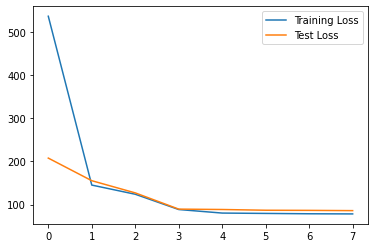

[9,     1] loss: 68.376
[9,     2] loss: 81.524
[9,     3] loss: 81.393
[9,     4] loss: 65.285
[9,     5] loss: 85.806
[9,     6] loss: 65.936
[9,     7] loss: 78.790
[9,     8] loss: 66.691
[9,     9] loss: 71.189
[9,    10] loss: 69.706
[9,    11] loss: 71.946
[9,    12] loss: 73.581
[9,    13] loss: 78.858
[9,    14] loss: 75.933
[9,    15] loss: 84.343
[9,    16] loss: 79.945
[9,    17] loss: 67.658
[9,    18] loss: 74.075
[9,    19] loss: 75.739
[9,    20] loss: 67.995
[9,    21] loss: 80.639
[9,    22] loss: 72.928
LOSS of the network on the train images after epoch 8 is 1638.3369522094727
Mean of the network on the train images after epoch 8 is 78.01604534330822
LOSS of the network on the test images: 769 %
Mean of the network on the train images after epoch 8 is 85.51301659478082


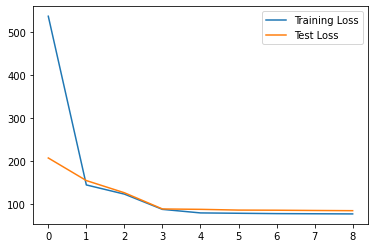

[10,     1] loss: 67.942
[10,     2] loss: 81.059
[10,     3] loss: 81.043
[10,     4] loss: 64.760
[10,     5] loss: 85.613
[10,     6] loss: 65.707
[10,     7] loss: 78.266
[10,     8] loss: 66.452
[10,     9] loss: 70.794
[10,    10] loss: 69.390
[10,    11] loss: 71.490
[10,    12] loss: 73.116
[10,    13] loss: 78.122
[10,    14] loss: 75.526
[10,    15] loss: 83.878
[10,    16] loss: 79.514
[10,    17] loss: 67.496
[10,    18] loss: 73.963
[10,    19] loss: 75.418
[10,    20] loss: 67.512
[10,    21] loss: 80.284
[10,    22] loss: 72.561
LOSS of the network on the train images after epoch 9 is 1629.9074172973633
Mean of the network on the train images after epoch 9 is 77.61463891892205
LOSS of the network on the test images: 766 %
Mean of the network on the train images after epoch 9 is 85.1490715874566


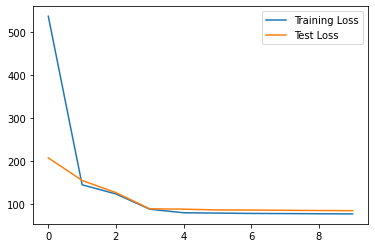

[11,     1] loss: 67.706
[11,     2] loss: 80.775
[11,     3] loss: 80.570
[11,     4] loss: 64.615
[11,     5] loss: 85.162
[11,     6] loss: 65.408
[11,     7] loss: 77.651
[11,     8] loss: 66.244
[11,     9] loss: 70.386
[11,    10] loss: 69.035
[11,    11] loss: 71.117
[11,    12] loss: 72.604
[11,    13] loss: 77.520
[11,    14] loss: 74.977
[11,    15] loss: 83.365
[11,    16] loss: 79.106
[11,    17] loss: 67.017
[11,    18] loss: 73.604
[11,    19] loss: 75.254
[11,    20] loss: 67.257
[11,    21] loss: 79.865
[11,    22] loss: 72.323
LOSS of the network on the train images after epoch 10 is 1621.5616607666016
Mean of the network on the train images after epoch 10 is 77.21722194126674
LOSS of the network on the test images: 762 %
Mean of the network on the train images after epoch 10 is 84.73801761203342


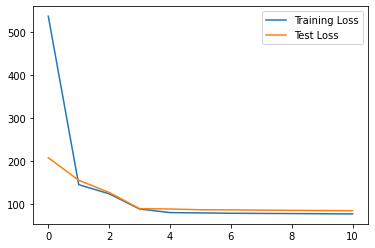

[12,     1] loss: 67.383
[12,     2] loss: 80.530
[12,     3] loss: 80.196
[12,     4] loss: 64.221
[12,     5] loss: 84.939
[12,     6] loss: 65.397
[12,     7] loss: 76.977
[12,     8] loss: 66.156
[12,     9] loss: 70.042
[12,    10] loss: 68.678
[12,    11] loss: 70.883
[12,    12] loss: 72.140
[12,    13] loss: 76.917
[12,    14] loss: 74.432
[12,    15] loss: 82.747
[12,    16] loss: 78.701
[12,    17] loss: 66.464
[12,    18] loss: 73.057
[12,    19] loss: 75.322
[12,    20] loss: 67.336
[12,    21] loss: 79.360
[12,    22] loss: 72.185
LOSS of the network on the train images after epoch 11 is 1614.0624771118164
Mean of the network on the train images after epoch 11 is 76.86011795770554
LOSS of the network on the test images: 759 %
Mean of the network on the train images after epoch 11 is 84.42781321207683


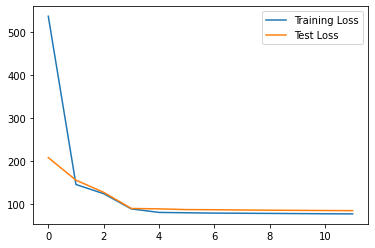

[13,     1] loss: 67.126
[13,     2] loss: 80.090
[13,     3] loss: 79.925
[13,     4] loss: 63.791
[13,     5] loss: 84.410
[13,     6] loss: 65.591
[13,     7] loss: 76.296
[13,     8] loss: 65.995
[13,     9] loss: 69.847
[13,    10] loss: 68.262
[13,    11] loss: 70.513
[13,    12] loss: 71.686
[13,    13] loss: 76.165
[13,    14] loss: 73.834
[13,    15] loss: 82.018
[13,    16] loss: 78.136
[13,    17] loss: 65.988
[13,    18] loss: 72.421
[13,    19] loss: 75.084
[13,    20] loss: 67.316
[13,    21] loss: 78.710
[13,    22] loss: 71.802
LOSS of the network on the train images after epoch 12 is 1605.0063972473145
Mean of the network on the train images after epoch 12 is 76.42887605939593
LOSS of the network on the test images: 755 %
Mean of the network on the train images after epoch 12 is 83.9803949991862


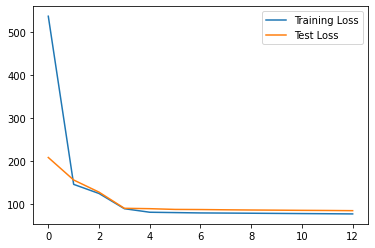

[14,     1] loss: 66.832
[14,     2] loss: 79.396
[14,     3] loss: 79.423
[14,     4] loss: 63.382
[14,     5] loss: 83.707
[14,     6] loss: 65.628
[14,     7] loss: 75.445
[14,     8] loss: 65.615
[14,     9] loss: 69.480
[14,    10] loss: 67.694
[14,    11] loss: 69.824
[14,    12] loss: 70.926
[14,    13] loss: 75.067
[14,    14] loss: 72.878
[14,    15] loss: 81.051
[14,    16] loss: 77.150
[14,    17] loss: 65.241
[14,    18] loss: 71.563
[14,    19] loss: 74.500
[14,    20] loss: 66.958
[14,    21] loss: 77.521
[14,    22] loss: 70.771
LOSS of the network on the train images after epoch 13 is 1590.050853729248
Mean of the network on the train images after epoch 13 is 75.71670732044038
LOSS of the network on the test images: 746 %
Mean of the network on the train images after epoch 13 is 82.89266459147136


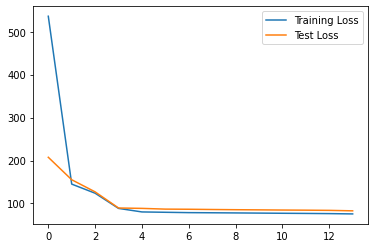

[15,     1] loss: 66.153
[15,     2] loss: 78.108
[15,     3] loss: 78.407
[15,     4] loss: 62.612
[15,     5] loss: 82.444
[15,     6] loss: 65.193
[15,     7] loss: 73.976
[15,     8] loss: 64.624
[15,     9] loss: 68.541
[15,    10] loss: 66.548
[15,    11] loss: 68.358
[15,    12] loss: 69.381
[15,    13] loss: 73.053
[15,    14] loss: 70.850
[15,    15] loss: 79.391
[15,    16] loss: 74.908
[15,    17] loss: 63.499
[15,    18] loss: 69.539
[15,    19] loss: 72.011
[15,    20] loss: 65.307
[15,    21] loss: 74.405
[15,    22] loss: 67.304
LOSS of the network on the train images after epoch 14 is 1554.6122207641602
Mean of the network on the train images after epoch 14 is 74.02915336972191
LOSS of the network on the test images: 716 %
Mean of the network on the train images after epoch 14 is 79.58083258734808


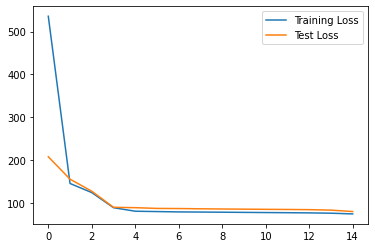

[16,     1] loss: 63.979
[16,     2] loss: 74.419
[16,     3] loss: 74.732
[16,     4] loss: 59.593
[16,     5] loss: 77.357
[16,     6] loss: 60.490
[16,     7] loss: 71.388
[16,     8] loss: 64.039
[16,     9] loss: 64.323
[16,    10] loss: 62.487
[16,    11] loss: 65.398
[16,    12] loss: 63.860
[16,    13] loss: 68.019
[16,    14] loss: 64.376
[16,    15] loss: 73.467
[16,    16] loss: 69.144
[16,    17] loss: 62.049
[16,    18] loss: 67.807
[16,    19] loss: 65.978
[16,    20] loss: 62.048
[16,    21] loss: 69.817
[16,    22] loss: 62.893
LOSS of the network on the train images after epoch 15 is 1467.6627197265625
Mean of the network on the train images after epoch 15 is 69.88870093936012
LOSS of the network on the test images: 707 %
Mean of the network on the train images after epoch 15 is 78.64031982421875


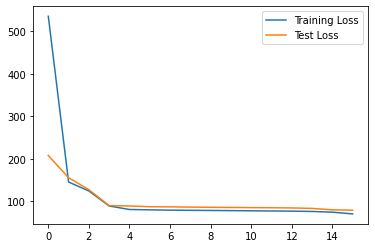

[17,     1] loss: 63.853
[17,     2] loss: 70.146
[17,     3] loss: 72.501
[17,     4] loss: 55.981
[17,     5] loss: 74.624
[17,     6] loss: 61.207
[17,     7] loss: 63.105
[17,     8] loss: 63.224
[17,     9] loss: 60.282
[17,    10] loss: 63.212
[17,    11] loss: 59.531
[17,    12] loss: 60.922
[17,    13] loss: 65.318
[17,    14] loss: 62.328
[17,    15] loss: 70.977
[17,    16] loss: 68.141
[17,    17] loss: 57.080
[17,    18] loss: 63.801
[17,    19] loss: 63.922
[17,    20] loss: 59.468
[17,    21] loss: 64.400
[17,    22] loss: 62.093
LOSS of the network on the train images after epoch 16 is 1406.1168937683105
Mean of the network on the train images after epoch 16 is 66.9579473223005
LOSS of the network on the test images: 644 %
Mean of the network on the train images after epoch 16 is 71.58296373155382


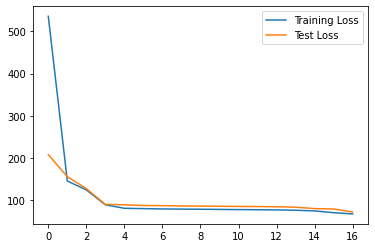

[18,     1] loss: 57.631
[18,     2] loss: 69.330
[18,     3] loss: 67.042
[18,     4] loss: 53.568
[18,     5] loss: 70.646
[18,     6] loss: 55.479
[18,     7] loss: 61.415
[18,     8] loss: 57.987
[18,     9] loss: 58.827
[18,    10] loss: 58.459
[18,    11] loss: 58.086
[18,    12] loss: 57.414
[18,    13] loss: 64.154
[18,    14] loss: 58.760
[18,    15] loss: 69.453
[18,    16] loss: 64.955
[18,    17] loss: 55.983
[18,    18] loss: 60.390
[18,    19] loss: 62.750
[18,    20] loss: 56.210
[18,    21] loss: 62.691
[18,    22] loss: 58.809
LOSS of the network on the train images after epoch 17 is 1340.0413932800293
Mean of the network on the train images after epoch 17 is 63.811494918096635
LOSS of the network on the test images: 631 %
Mean of the network on the train images after epoch 17 is 70.19810316297743


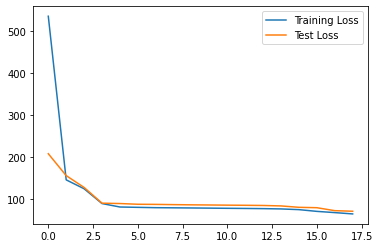

[19,     1] loss: 56.603
[19,     2] loss: 66.322
[19,     3] loss: 65.186
[19,     4] loss: 51.263
[19,     5] loss: 69.708
[19,     6] loss: 53.559
[19,     7] loss: 59.922
[19,     8] loss: 56.712
[19,     9] loss: 57.587
[19,    10] loss: 56.770
[19,    11] loss: 56.600
[19,    12] loss: 55.819
[19,    13] loss: 62.539
[19,    14] loss: 57.335
[19,    15] loss: 68.001
[19,    16] loss: 63.331
[19,    17] loss: 54.884
[19,    18] loss: 59.530
[19,    19] loss: 61.589
[19,    20] loss: 55.590
[19,    21] loss: 61.112
[19,    22] loss: 58.036
LOSS of the network on the train images after epoch 18 is 1307.9982261657715
Mean of the network on the train images after epoch 18 is 62.28562981741769
LOSS of the network on the test images: 621 %
Mean of the network on the train images after epoch 18 is 69.04723612467448


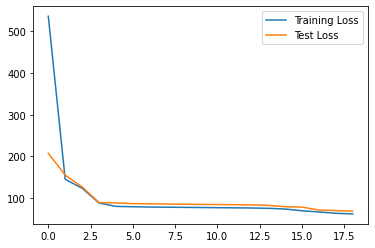

[20,     1] loss: 55.736
[20,     2] loss: 65.398
[20,     3] loss: 64.036
[20,     4] loss: 50.755
[20,     5] loss: 68.180
[20,     6] loss: 52.730
[20,     7] loss: 58.752
[20,     8] loss: 56.015
[20,     9] loss: 56.295
[20,    10] loss: 55.909
[20,    11] loss: 55.312
[20,    12] loss: 54.996
[20,    13] loss: 61.400
[20,    14] loss: 55.956
[20,    15] loss: 66.446
[20,    16] loss: 62.294
[20,    17] loss: 53.991
[20,    18] loss: 58.148
[20,    19] loss: 60.350
[20,    20] loss: 54.262
[20,    21] loss: 59.591
[20,    22] loss: 56.884
LOSS of the network on the train images after epoch 19 is 1283.434928894043
Mean of the network on the train images after epoch 19 is 61.11594899495443
LOSS of the network on the test images: 611 %
Mean of the network on the train images after epoch 19 is 67.9544414944119


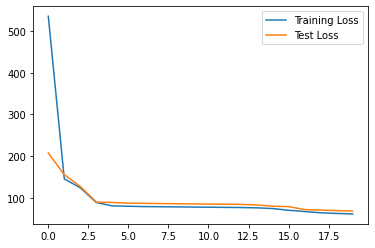

[21,     1] loss: 54.737
[21,     2] loss: 64.042
[21,     3] loss: 62.366
[21,     4] loss: 49.987
[21,     5] loss: 67.017
[21,     6] loss: 51.756
[21,     7] loss: 57.510
[21,     8] loss: 55.199
[21,     9] loss: 55.242
[21,    10] loss: 54.647
[21,    11] loss: 54.133
[21,    12] loss: 53.757
[21,    13] loss: 59.838
[21,    14] loss: 54.605
[21,    15] loss: 64.948
[21,    16] loss: 60.935
[21,    17] loss: 52.998
[21,    18] loss: 56.970
[21,    19] loss: 59.165
[21,    20] loss: 53.101
[21,    21] loss: 58.288
[21,    22] loss: 55.673
LOSS of the network on the train images after epoch 20 is 1256.9148063659668
Mean of the network on the train images after epoch 20 is 59.85308601742699
LOSS of the network on the test images: 601 %
Mean of the network on the train images after epoch 20 is 66.80395634969075


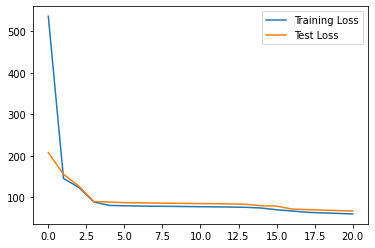

[22,     1] loss: 53.574
[22,     2] loss: 62.787
[22,     3] loss: 60.878
[22,     4] loss: 49.343
[22,     5] loss: 65.493
[22,     6] loss: 50.490
[22,     7] loss: 56.341
[22,     8] loss: 54.300
[22,     9] loss: 54.162
[22,    10] loss: 53.658
[22,    11] loss: 53.064
[22,    12] loss: 52.641
[22,    13] loss: 58.717
[22,    14] loss: 53.356
[22,    15] loss: 63.066
[22,    16] loss: 59.690
[22,    17] loss: 51.642
[22,    18] loss: 55.180
[22,    19] loss: 57.760
[22,    20] loss: 51.469
[22,    21] loss: 57.229
[22,    22] loss: 54.136
LOSS of the network on the train images after epoch 21 is 1228.9757537841797
Mean of the network on the train images after epoch 21 is 58.52265494210379
LOSS of the network on the test images: 593 %
Mean of the network on the train images after epoch 21 is 65.9115253024631


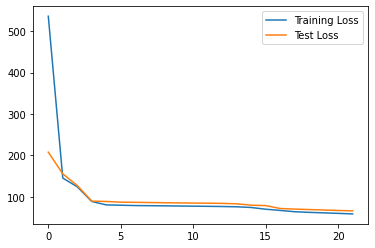

[23,     1] loss: 52.446
[23,     2] loss: 61.262
[23,     3] loss: 59.425
[23,     4] loss: 48.915
[23,     5] loss: 63.830
[23,     6] loss: 49.339
[23,     7] loss: 55.121
[23,     8] loss: 53.253
[23,     9] loss: 53.508
[23,    10] loss: 52.578
[23,    11] loss: 51.678
[23,    12] loss: 51.528
[23,    13] loss: 56.885
[23,    14] loss: 52.390
[23,    15] loss: 61.478
[23,    16] loss: 58.280
[23,    17] loss: 50.468
[23,    18] loss: 53.726
[23,    19] loss: 56.369
[23,    20] loss: 50.212
[23,    21] loss: 55.778
[23,    22] loss: 52.606
LOSS of the network on the train images after epoch 22 is 1201.0741271972656
Mean of the network on the train images after epoch 22 is 57.19400605701265
LOSS of the network on the test images: 585 %
Mean of the network on the train images after epoch 22 is 65.05725140041775


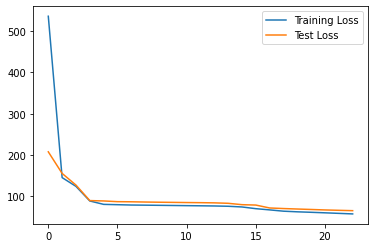

[24,     1] loss: 51.358
[24,     2] loss: 59.964
[24,     3] loss: 57.810
[24,     4] loss: 48.181
[24,     5] loss: 62.038
[24,     6] loss: 48.491
[24,     7] loss: 54.112
[24,     8] loss: 52.036
[24,     9] loss: 52.362
[24,    10] loss: 51.451
[24,    11] loss: 50.474
[24,    12] loss: 50.615
[24,    13] loss: 55.068
[24,    14] loss: 50.634
[24,    15] loss: 59.779
[24,    16] loss: 56.916
[24,    17] loss: 49.161
[24,    18] loss: 52.016
[24,    19] loss: 54.541
[24,    20] loss: 48.277
[24,    21] loss: 54.727
[24,    22] loss: 51.402
LOSS of the network on the train images after epoch 23 is 1171.4156684875488
Mean of the network on the train images after epoch 23 is 55.781698499407085
LOSS of the network on the test images: 576 %
Mean of the network on the train images after epoch 23 is 64.04980850219727


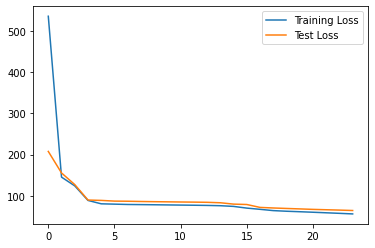

[25,     1] loss: 50.120
[25,     2] loss: 58.510
[25,     3] loss: 55.777
[25,     4] loss: 47.545
[25,     5] loss: 60.585
[25,     6] loss: 47.169
[25,     7] loss: 52.619
[25,     8] loss: 51.000
[25,     9] loss: 51.258
[25,    10] loss: 50.697
[25,    11] loss: 49.209
[25,    12] loss: 49.060
[25,    13] loss: 53.584
[25,    14] loss: 48.953
[25,    15] loss: 58.114
[25,    16] loss: 55.871
[25,    17] loss: 47.690
[25,    18] loss: 50.385
[25,    19] loss: 53.196
[25,    20] loss: 46.394
[25,    21] loss: 53.590
[25,    22] loss: 50.106
LOSS of the network on the train images after epoch 24 is 1141.4308319091797
Mean of the network on the train images after epoch 24 is 54.35384913853237
LOSS of the network on the test images: 565 %
Mean of the network on the train images after epoch 24 is 62.85307608710395


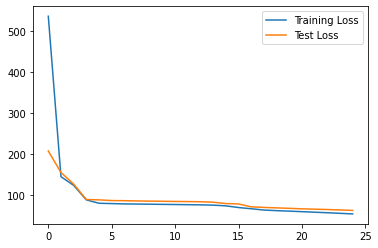

[26,     1] loss: 48.856
[26,     2] loss: 57.097
[26,     3] loss: 54.442
[26,     4] loss: 46.565
[26,     5] loss: 59.033
[26,     6] loss: 45.987
[26,     7] loss: 51.012
[26,     8] loss: 50.162
[26,     9] loss: 50.350
[26,    10] loss: 49.611
[26,    11] loss: 48.087
[26,    12] loss: 47.782
[26,    13] loss: 52.109
[26,    14] loss: 47.755
[26,    15] loss: 56.508
[26,    16] loss: 54.870
[26,    17] loss: 46.706
[26,    18] loss: 48.816
[26,    19] loss: 52.070
[26,    20] loss: 45.010
[26,    21] loss: 52.056
[26,    22] loss: 49.233
LOSS of the network on the train images after epoch 25 is 1114.1181755065918
Mean of the network on the train images after epoch 25 is 53.05324645269485
LOSS of the network on the test images: 555 %
Mean of the network on the train images after epoch 25 is 61.686780293782554


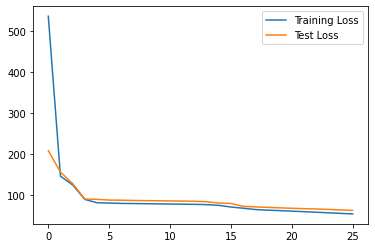

[27,     1] loss: 47.732
[27,     2] loss: 55.912
[27,     3] loss: 52.984
[27,     4] loss: 45.564
[27,     5] loss: 57.640
[27,     6] loss: 44.783
[27,     7] loss: 49.577
[27,     8] loss: 49.419
[27,     9] loss: 49.616
[27,    10] loss: 48.295
[27,    11] loss: 47.126
[27,    12] loss: 46.727
[27,    13] loss: 50.658
[27,    14] loss: 46.841
[27,    15] loss: 55.106
[27,    16] loss: 53.799
[27,    17] loss: 45.532
[27,    18] loss: 47.678
[27,    19] loss: 50.830
[27,    20] loss: 43.798
[27,    21] loss: 50.614
[27,    22] loss: 48.442
LOSS of the network on the train images after epoch 26 is 1088.6727333068848
Mean of the network on the train images after epoch 26 is 51.84155872889927
LOSS of the network on the test images: 545 %
Mean of the network on the train images after epoch 26 is 60.564080980088974


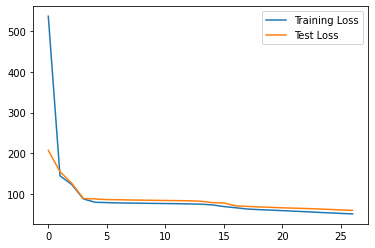

[28,     1] loss: 46.634
[28,     2] loss: 54.677
[28,     3] loss: 51.745
[28,     4] loss: 44.648
[28,     5] loss: 56.080
[28,     6] loss: 43.697
[28,     7] loss: 48.369
[28,     8] loss: 48.470
[28,     9] loss: 48.700
[28,    10] loss: 47.241
[28,    11] loss: 46.115
[28,    12] loss: 45.760
[28,    13] loss: 49.381
[28,    14] loss: 45.859
[28,    15] loss: 53.784
[28,    16] loss: 52.660
[28,    17] loss: 44.581
[28,    18] loss: 46.638
[28,    19] loss: 49.616
[28,    20] loss: 42.820
[28,    21] loss: 49.772
[28,    22] loss: 47.340
LOSS of the network on the train images after epoch 27 is 1064.5862350463867
Mean of the network on the train images after epoch 27 is 50.69458262125651
LOSS of the network on the test images: 537 %
Mean of the network on the train images after epoch 27 is 59.7343372768826


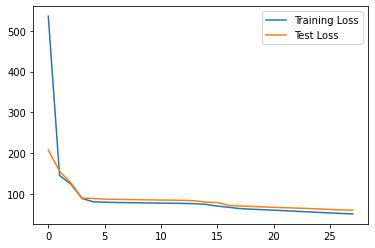

[29,     1] loss: 45.750
[29,     2] loss: 53.648
[29,     3] loss: 50.915
[29,     4] loss: 43.813
[29,     5] loss: 54.868
[29,     6] loss: 42.994
[29,     7] loss: 47.356
[29,     8] loss: 47.563
[29,     9] loss: 47.851
[29,    10] loss: 46.655
[29,    11] loss: 45.367
[29,    12] loss: 44.890
[29,    13] loss: 48.523
[29,    14] loss: 45.005
[29,    15] loss: 52.438
[29,    16] loss: 51.746
[29,    17] loss: 43.935
[29,    18] loss: 45.996
[29,    19] loss: 48.508
[29,    20] loss: 42.366
[29,    21] loss: 49.558
[29,    22] loss: 46.546
LOSS of the network on the train images after epoch 28 is 1046.2911186218262
Mean of the network on the train images after epoch 28 is 49.82338660103934
LOSS of the network on the test images: 532 %
Mean of the network on the train images after epoch 28 is 59.175132751464844


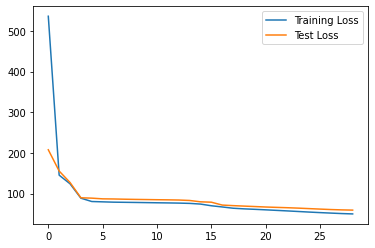

[30,     1] loss: 45.023
[30,     2] loss: 53.095
[30,     3] loss: 49.935
[30,     4] loss: 43.274
[30,     5] loss: 54.033
[30,     6] loss: 42.449
[30,     7] loss: 46.533
[30,     8] loss: 47.144
[30,     9] loss: 47.011
[30,    10] loss: 45.418
[30,    11] loss: 44.449
[30,    12] loss: 44.140
[30,    13] loss: 47.676
[30,    14] loss: 44.040
[30,    15] loss: 51.170
[30,    16] loss: 50.855
[30,    17] loss: 42.775
[30,    18] loss: 45.050
[30,    19] loss: 47.540
[30,    20] loss: 41.262
[30,    21] loss: 47.722
[30,    22] loss: 45.581
LOSS of the network on the train images after epoch 29 is 1026.1740684509277
Mean of the network on the train images after epoch 29 is 48.865431830996556
LOSS of the network on the test images: 527 %
Mean of the network on the train images after epoch 29 is 58.65970018174913


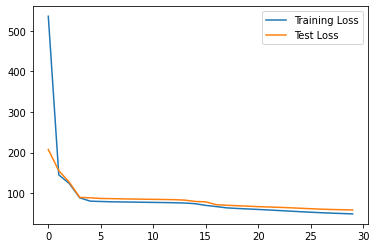

Finished Training


In [30]:
train_loss_graph = []
test_loss_graph = []

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
      
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)

print('Finished Training')

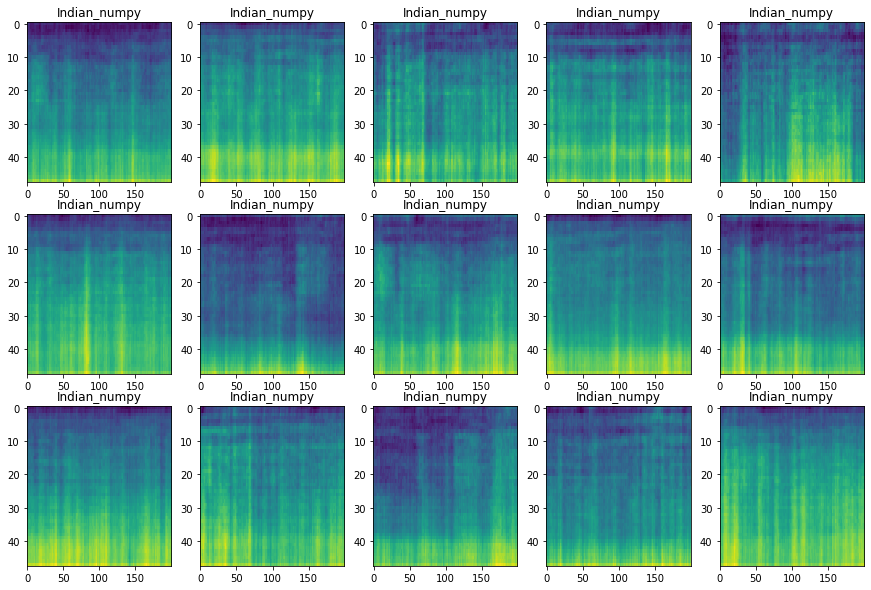

In [ ]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

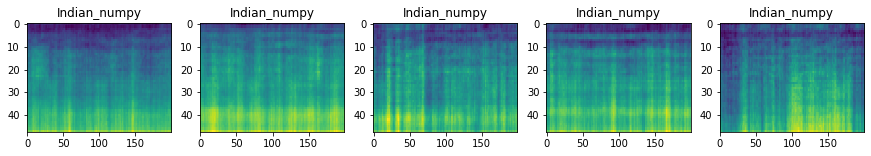

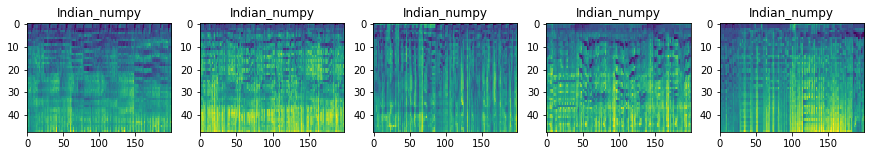

In [ ]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [ ]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [ ]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Strict data separation

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


In [ ]:
# get some random training images
dataiter = iter(trainloader_combined)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
# get some random training images
dataiter = iter(testloader_combined)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
id_test = 0
with torch.no_grad():
    for data_test in testloader_combined:
        inputs, labels, fileNames = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




In [ ]:
id_train = 0
with torch.no_grad():
    for data in trainloader_combined:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_train = id_train + 1